<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/PSF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
import scipy.optimize as opt
from astropy.convolution import convolve
from matplotlib import colors
from time import perf_counter
from astropy.modeling import models, fitting

matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size']=10

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 473, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 473 (delta 49), reused 0 (delta 0), pack-reused 375
Receiving objects: 100% (473/473), 54.47 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [4]:
cd INSIST/data

/content/INSIST/data


# **Convolutions**

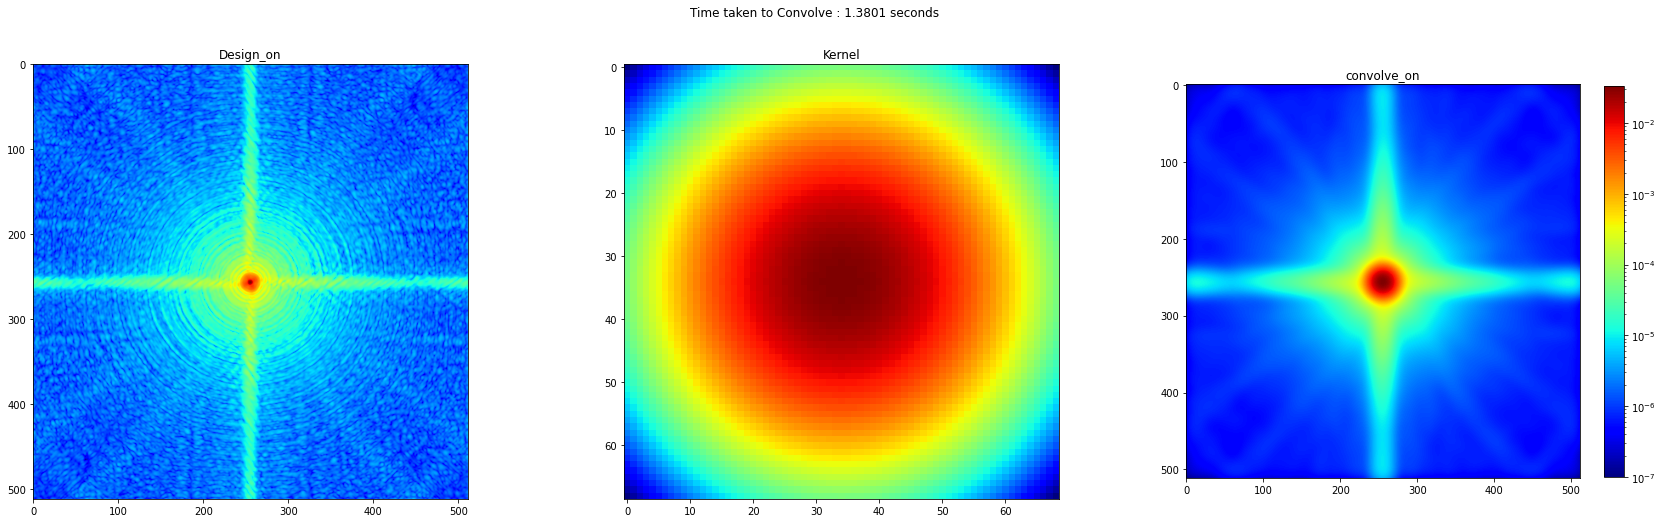

In [5]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(8.5,8.5,x_size=69,y_size=69)
start = perf_counter()
astropy_conv_on = convolve(On_PSF, kernel) # Astropy convolution

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(astropy_conv_on, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

In [6]:
data     = torch.tensor(On_PSF).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

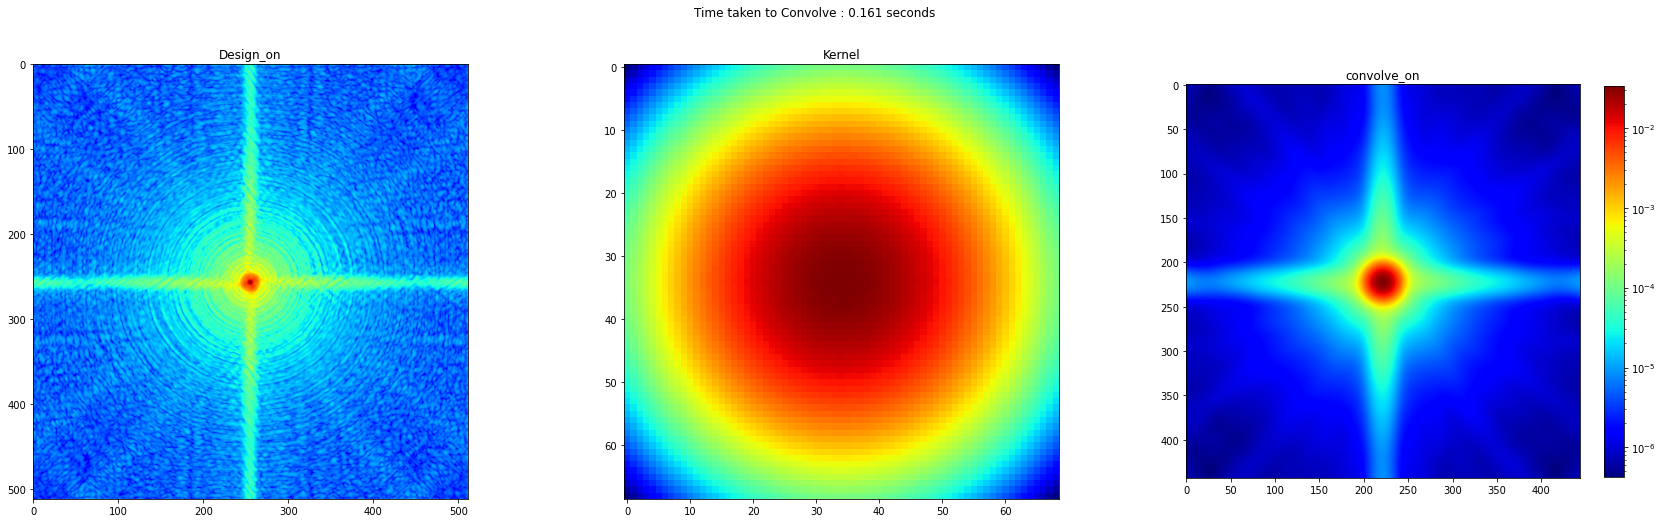

In [7]:
On_PSF = np.loadtxt("on_axis_nor.TXT") # Read PSF file
On_PSF = (0.75*On_PSF)/On_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(On_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(8.5,8.5,x_size=69,y_size=69)
kernel.normalize()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,512,512)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

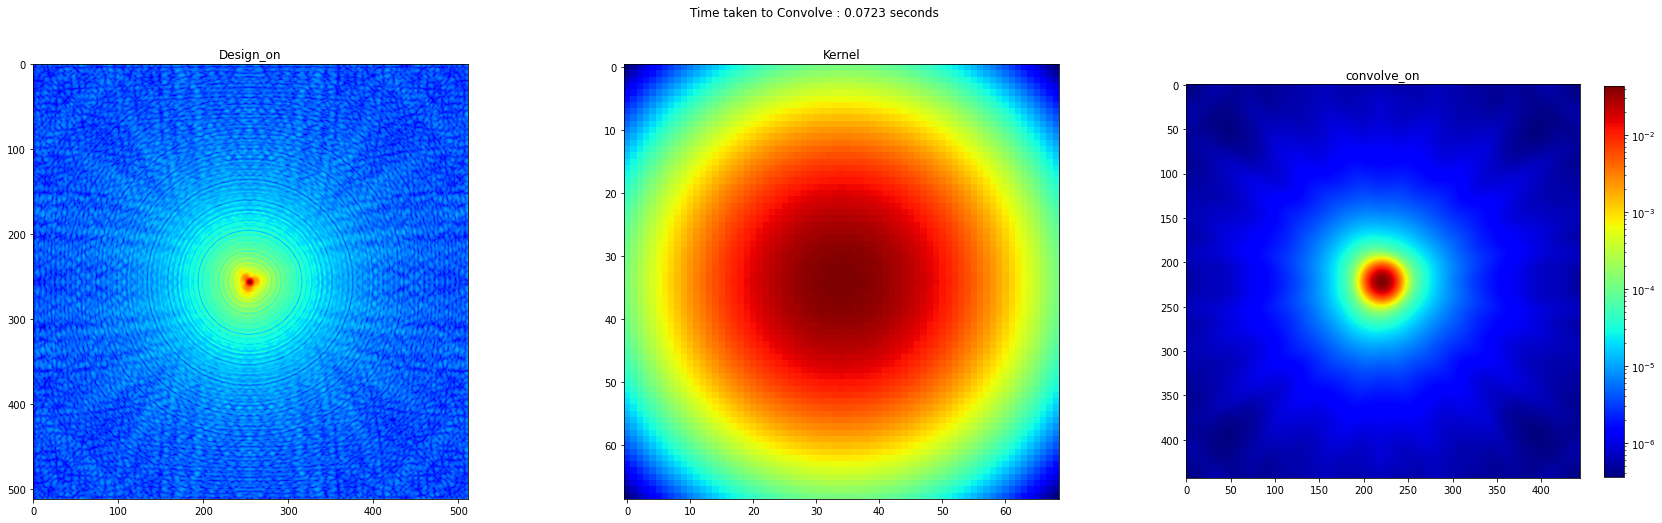

In [40]:
Off_PSF =np.loadtxt("off_axis.TXT",skiprows=18,encoding='latin-1') # Read PSF file
Off_PSF = (1*Off_PSF)/Off_PSF.max()

fig, ax = plt.subplots(1,3, figsize = (30,8))
ax[0].set_title("Design_on")
ax[0].imshow(Off_PSF, cmap="jet",norm=colors.LogNorm())

kernel = Gaussian2DKernel(8.5,8.5,x_size=69,y_size=69)
kernel.normalize()

data     = torch.tensor(Off_PSF).unsqueeze(0).cuda()
kernel_t = torch.tensor(kernel.array).cuda()

start = perf_counter()
out = F.conv2d(Variable(data.view(1,1,512,512)),Variable(kernel_t.view(1,1,69,69))).squeeze().cpu().numpy()

stop  = perf_counter()- start

ax[1].set_title("Kernel")
ax[1].imshow(kernel, cmap="jet",norm=colors.LogNorm())

ax[2].set_title("convolve_on")
im_on = ax[2].imshow(out, cmap="jet",norm=colors.LogNorm())
plt.colorbar(im_on,shrink=0.9)
fig.suptitle(f"Time taken to Convolve : {np.round(stop,4)} seconds");

# **Binning**

In [56]:
Flux = On_PSF    #Off_PSF

In [57]:
Flux.shape, Flux.sum()

((512, 512), 20.77119150973575)

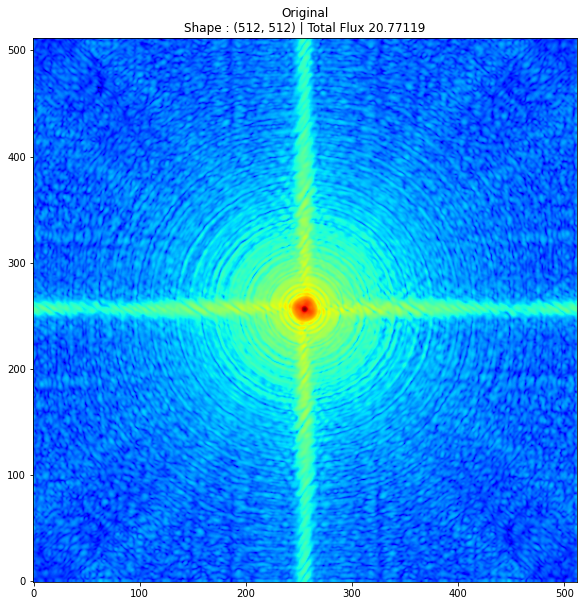

In [58]:
plt.imshow(np.log10(Flux/Flux.max()),origin = 'lower',cmap='jet')
plt.title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux.shape,number=Flux.sum(), digits=5));

In [61]:
Flux_p = np.pad(Flux,((8,0),(0,8)),mode='constant')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


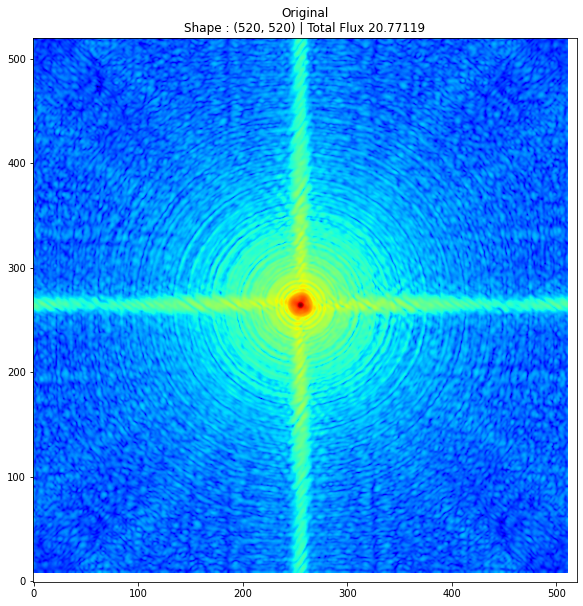

In [62]:
plt.imshow(np.log10(Flux_p/Flux_p.max()),origin = 'lower',cmap='jet')
plt.title('Original\nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_p.shape,number=Flux_p.sum(), digits=5));

In [63]:
Flux_b = Flux_p.reshape(52,10, 52,10).sum(axis=3).sum(axis=1) # Flux.sum(axis=3).sum(axis=1)

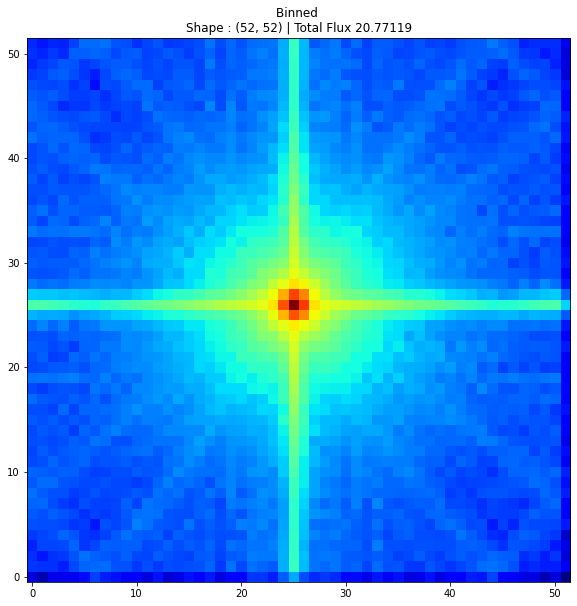

In [66]:
plt.imshow(np.log10(Flux_b/Flux_b.max()),origin = 'lower',cmap='jet')
plt.title('Binned \nShape : {shape} | Total Flux {number:.{digits}f}'.format(shape = Flux_b.shape,number=Flux_b.sum(), digits=5));

In [65]:
np.where(Flux_b==Flux_b.max())

(array([26]), array([25]))

# **Ellitpical fitting**

In [67]:
surf = np.loadtxt('nominal6.txt',skiprows=1)

with open('nominal6.txt','r') as f:
  columns = f.readline()[1:-1].split('\t')
  f.close()
df = pd.DataFrame(surf, columns = columns )

In [68]:
df

,X-Field,Y-Field,Sigma,e1,e2,EPS
0,-0.2500,-0.25,6.912,-0.001918,-0.000769,0.002066
1,-0.2339,-0.25,6.904,-0.001448,-0.000084,0.001451
2,-0.2177,-0.25,6.902,-0.001600,0.000234,0.001617
3,-0.2016,-0.25,6.904,-0.002247,0.000294,0.002266
4,-0.1855,-0.25,6.911,-0.003276,0.000188,0.003282
...,...,...,...,...,...,...
1019,0.1855,0.25,6.938,-0.007314,-0.000562,0.007336
1020,0.2016,0.25,6.943,-0.007774,-0.000671,0.007803
1021,0.2177,0.25,6.949,-0.008302,-0.000789,0.008339
1022,0.2339,0.25,6.955,-0.008883,-0.000908,0.008929


In [69]:
x = df['X-Field'].values
y = df['X-Field'].values
z = df['Sigma'].values

In [70]:
xx,yy = np.meshgrid(x[:32],y[:32])

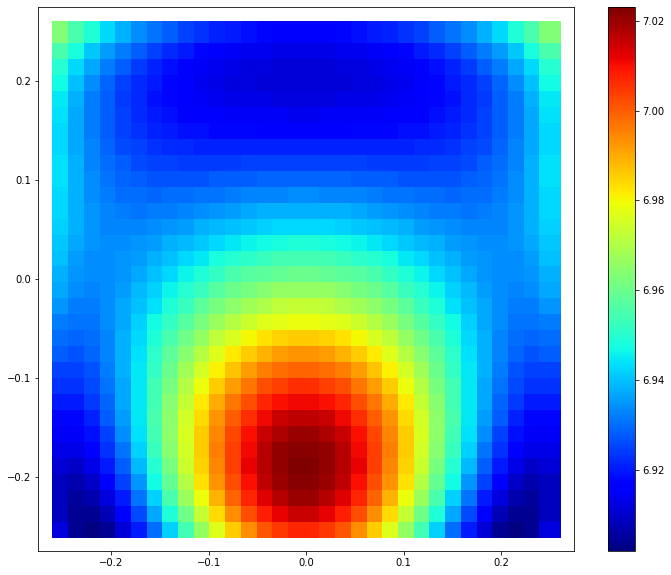

In [78]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
img = ax.scatter(xx,yy,c=z.reshape(32,32), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
plt.colorbar(img)

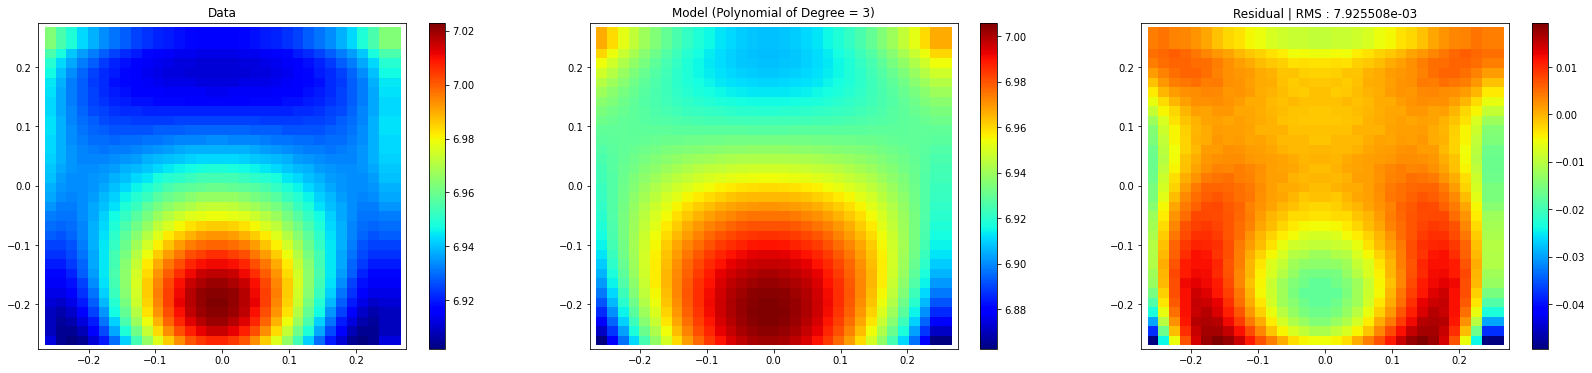

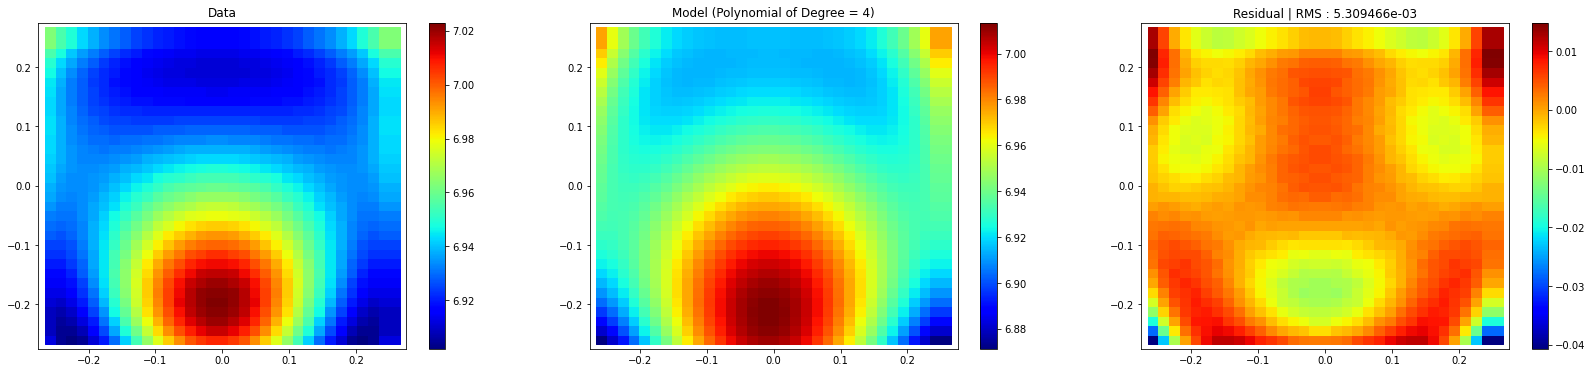

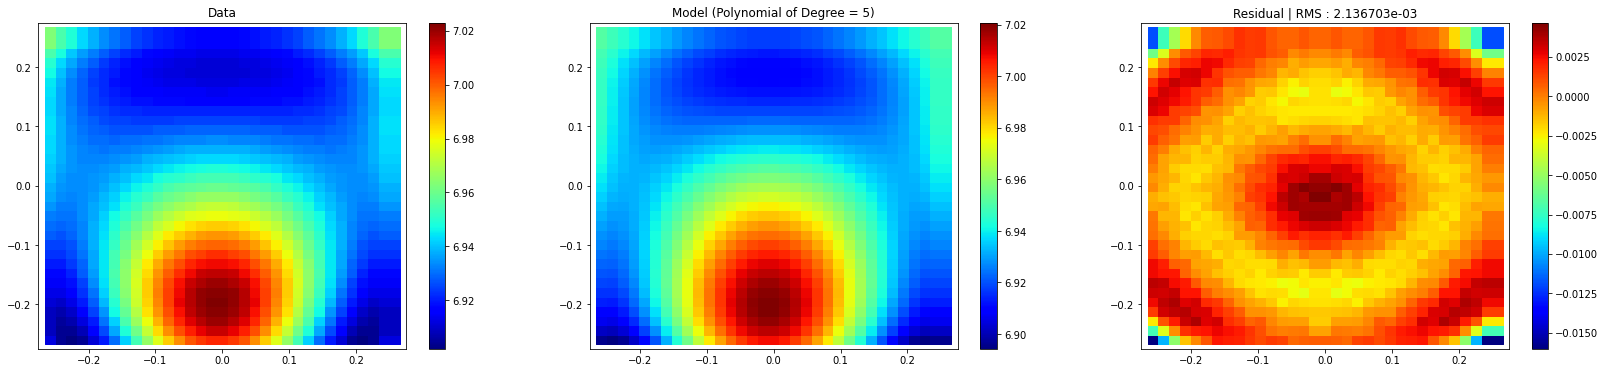

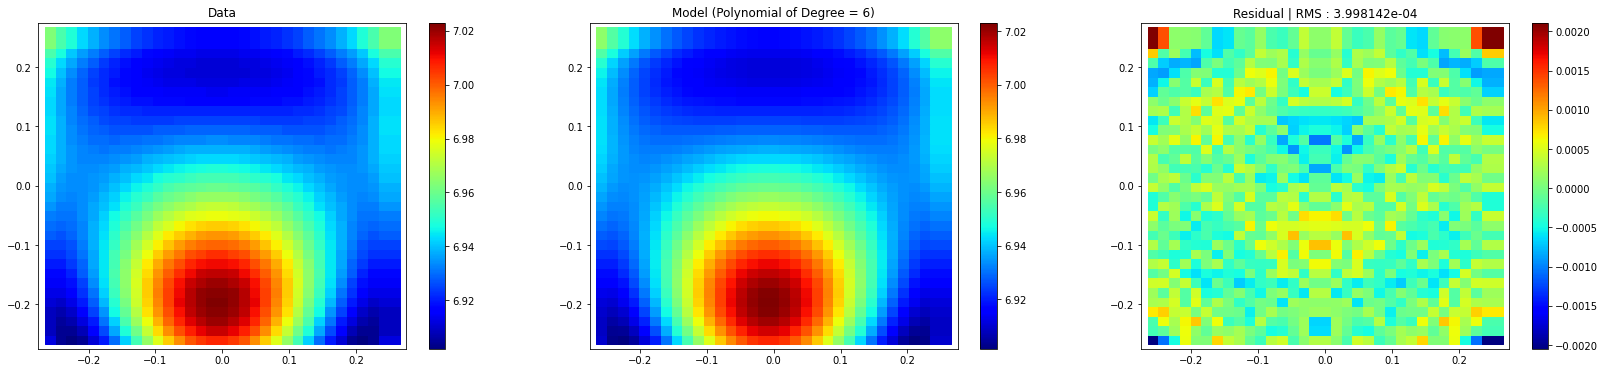

In [83]:
for deg in [3,4,5,6]:
  init = models.Polynomial2D(deg)

  fit = fitting.LevMarLSQFitter()

  model = fit(init,x=xx,y=yy,z=z.reshape(32,32))
  fig, ax = plt.subplots(1,3,figsize=(28,6))
  resid = model(xx,yy)-z.reshape(32,32)

  img0 = ax[0].scatter(xx,yy,c = z.reshape(32,32) , marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img0, ax=ax[0])
  ax[0].set_title('Data')

  img1 = ax[1].scatter(xx,yy,c = model(xx,yy), marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img1, ax=ax[1])
  ax[1].set_title(f'Model (Polynomial of Degree = {deg})')

  img2 = ax[2].scatter(xx,yy,c = resid, marker="s", s = (1500./fig.dpi)**2,cmap='jet')
  plt.colorbar(img2, ax=ax[2])
  ax[2].set_title('Residual | RMS : {:e}'.format(np.sqrt(np.mean(resid**2))))

  plt.show()